# INFO8010: Homework 2

In the previous homework, you learned how to program your first neural network starting from the very first principles of deep learning. If you managed to solve last assignment without any problems **congratulations!** If that was not the case **don't worry**, here's a second assignment for you which you can use to get better at deep learning.

In this homework we will see some slighly more complicated deep learning concepts: we will start by taking a look at some of PyTorch's functionalities that are necessary for training deep networks efficiently. We will then train our first neural networks for tackling different image classification tasks, learn to build custom datasets and explore how to train a CNN.  

The strucutre of the notebook is identical to the one of the previous homework. Similarly to last time, you have to submit the notebook **with your solutions** to the exercises. When you encounter a `# your code` comment, you have to write some code yourself and you have to discuss the code/results when you see the instruction

> your discussion

Without further ado let's start by importing the libraries we will need throughout this assignment!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from PIL import Image
from torchvision import datasets, transforms, utils

In [2]:
# As of 2022/02/23, the CIFAR10 dataset SSL certificate is outdated which prevents its download.
# The following deactivates the verification of the SSL certificates, but
# never reproduce this unless you absolutely trust the source.
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## 1. Dataloaders

Today's first concept are PyTorch's dataloaders. As you have seen during the theoretical lectures, one of the main ingredients for successfully training deep learning models is data, **lots of data**.

As you can easily imagine, it is not possible to load datasets of millions of images into the memory of your machine. Furthermore, these images come in a form that does not make it possible to exploit the tensor operations we have seen in the previous assignment.

To deal with these issues (and many more of them) we can use [dataloaders](https://pytorch.org/docs/stable/data.html), a data loading utility that allows us to deal with large datasets efficiently. In what follows, you are given your first example of dataloader which will use the popular [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, transform=transform)

Files already downloaded and verified


Let's explain what we just did. Thanks to PyTorch's [torchvision](https://pytorch.org/vision/stable/index.html) sub-library, we just downloaded the CIFAR10 dataset on our machine. The dataset was stored in the `./data` folder and comes in two different forms thanks to the use of the `train` flag: a version that can be used as training set, and a version that can be used as testing set. These two datasets are subclasses of `torch`'s `data.Dataset` class. We will see later what this `data.Dataset` class consists in exactly. Torchvision also allows us to define a set of image transformations which we have defined at the beginning of this cell: in this case we would like to convert our images to tensors, see the [documentation](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ToTensor) for an exact description of this transformation.

Now that we have defined which dataset we would like to use, and the form in which we would like to have our images, we can create our first data loader. Data loaders are objects over which you can iterate and that load, transform and return mini-batches of inputs/targets at each iteration. The advantage of data loaders is that they (can) perform pre-processing of the data in parallel, i.e. in several concurrent worker pools.

Here, we create two data loaders that return mini-batches of 4 elements at each iteration. When using stochastic gradient descent (SGD), the training data loader should shuffle the training dataset.

In [4]:
trainloader = data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Before training anything, let's take a look at the images we just downloaded.

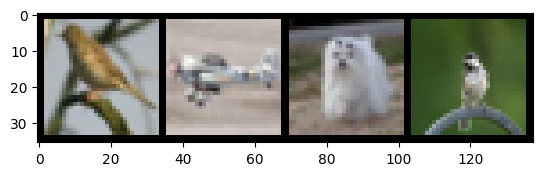

bird plane dog bird


In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def show_images(img):
    plt.imshow(transforms.functional.to_pil_image(img))
    plt.show()

images, labels = next(iter(trainloader))
show_images(utils.make_grid(images))
print(*[classes[l] for l in labels])

The `transforms` module comes also in as very handy for performing other type of data transformations: here's an example which transforms the CIFAR10 images into gray scaled images.

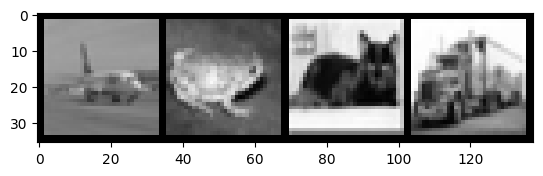

plane frog cat truck


In [6]:
transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor()])
gray_scaled_trainset = datasets.CIFAR10(root='./data', train=True, transform=transform)
gray_scaled_trainloader = data.DataLoader(gray_scaled_trainset, batch_size=4, shuffle=True, num_workers=2)

images, labels = next(iter(gray_scaled_trainloader))
show_images(utils.make_grid(images))
print(*[classes[l] for l in labels])

### 1.1 Transforms

Al remembered from the theoretical lectures that one way to make neural networks converge faster is to **normalize** the pixel values. He wrote the following code snippet to normalize his training set, but he encountered an error.

In [7]:
transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.ToTensor(),
])
bugged_trainset = datasets.CIFAR10(root='./data', train=True, transform=transform)
bugged_trainloader = data.DataLoader(bugged_trainset, batch_size=4, shuffle=True, num_workers=2)

images, labels = next(iter(bugged_trainloader))
show_images(utils.make_grid(images))  # should look weird due to normalization
print(*[classes[l] for l in labels])

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\Users\leiya\anaconda3\envs\dataprj\Lib\site-packages\torch\utils\data\_utils\worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\leiya\anaconda3\envs\dataprj\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "c:\Users\leiya\anaconda3\envs\dataprj\Lib\site-packages\torchvision\datasets\cifar.py", line 119, in __getitem__
    img = self.transform(img)
          ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\leiya\anaconda3\envs\dataprj\Lib\site-packages\torchvision\transforms\transforms.py", line 95, in __call__
    img = t(img)
          ^^^^^^
  File "c:\Users\leiya\anaconda3\envs\dataprj\Lib\site-packages\torch\nn\modules\module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\leiya\anaconda3\envs\dataprj\Lib\site-packages\torch\nn\modules\module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\leiya\anaconda3\envs\dataprj\Lib\site-packages\torchvision\transforms\transforms.py", line 277, in forward
    return F.normalize(tensor, self.mean, self.std, self.inplace)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\leiya\anaconda3\envs\dataprj\Lib\site-packages\torchvision\transforms\functional.py", line 348, in normalize
    raise TypeError(f"img should be Tensor Image. Got {type(tensor)}")
TypeError: img should be Tensor Image. Got <class 'PIL.Image.Image'>


Fix his mistake.

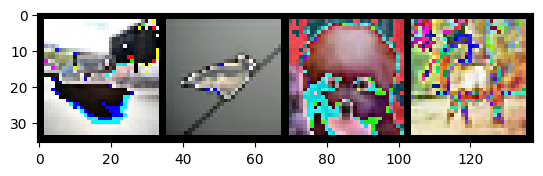

truck bird dog deer


In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
corrected_trainset = datasets.CIFAR10(root='./data', train=True, transform=transform)
corrected_trainloader = data.DataLoader(corrected_trainset, batch_size=4, shuffle=True, num_workers=2)

images, labels = next(iter(corrected_trainloader))
show_images(utils.make_grid(images))  # should look normal after correct normalization
print(*[classes[l] for l in labels])

Al also remembers that, with image datasets, a common practice to increase the robustness of neural networks is **data augmentation**. He wants to apply random flips (vertical and horizontal) and random color changes to his training set, but he does not know how to. Could you help him?

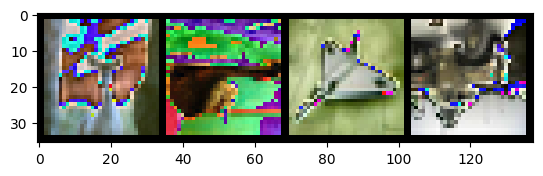

deer cat plane truck


In [11]:
transform = transforms.Compose([
    transforms.RandomVerticalFlip(), # Random vertical flips
    transforms.RandomHorizontalFlip(), # Random horizontal flips
    transforms.ColorJitter(), # Random color changes
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
augmented_trainset = datasets.CIFAR10(root='./data', train=True, transform=transform)
augmented_trainloader = data.DataLoader(augmented_trainset, batch_size=4, shuffle=True, num_workers=2)

images, labels = next(iter(augmented_trainloader))
show_images(utils.make_grid(images))
print(*[classes[l] for l in labels])

### 1.2 Running operations on a GPU

As you may know, one important aspect of deep learning is that large models can be trained efficiently on specialized hardwares such as Graphical Processing Units (GPUs) or Tensorial Processing Units (TPUs). PyTorch allows you to perform operations on GPUs very easily by transferring the concerned models and/or tensors to GPUs.

However, to do so, you need a CUDA compatible GPU.

In [6]:
torch.cuda.is_available()

True

If the result of the previous cell is `True`, everything is ready to run on the GPU and you can continue. Otherwise it means you do not have any GPU that is compatible with the `torch` version installed on your machine. In this case, we invite you to use [Google Colab](https://colab.research.google.com/) to do the rest of this homework. Do not forget to ask Colab for a GPU (in Runtime > Change runtime type > Hardware accelerator).

In [7]:
device = 'cuda'

Let's compare the speed of tensor operations on GPU and CPU.

In [14]:
A = torch.randn(1000, 100000)
B = torch.randn(100000, 1)

# on CPU
%timeit A @ B

17.4 ms ± 751 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
A = torch.randn((1000, 100000), device=device)
B = torch.randn((100000, 1), device=device)

# on GPU
%timeit A @ B

1.08 ms ± 14.8 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Instead of directly creating a tensor on the GPU you may also transfer a model or a tensor on the GPU, for example we can transfer a simple MLP on the GPU and then back to the CPU as follows.

In [16]:
# create MLP on CPU
mlp = nn.Sequential(
    nn.Linear(3, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 1),
    nn.Sigmoid(),
)

# forward pass on CPU
x = torch.randn(256, 3)
%timeit mlp(x)

# transfer MLP to GPU (in-place)
mlp.to(device)

# forward pass on GPU
x = x.to(device)
%timeit mlp(x)

# release the GPU memory
mlp.to('cpu')
x = x.to('cpu')

1.1 ms ± 56.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
331 μs ± 13.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


As you may notice, computations are much faster on the GPU. However, data transfer between GPU and CPU (and vice-versa) is usually very slow. We recommend to reduce the transfers of data between GPU and CPU as much as possible. For example when you want to save your loss after each iteration, in order to avoid a memory leak, you should prefer doing `.detach()` rather than `.cpu()` or `.item()`.

## 2.  Classifying the CIFAR10 dataset with an MLP

Now that you know how to handle datasets, we are ready to properly train today's first deep learning model on the CIFAR10 dataset. Before we dive into it, **do not underestimate** the importance of properly pre-processing the data before training neural networks. This step is as important as defining the neural architectures themselves, but is very often overlooked.

In this exercise you are provided with an already defined multi-layer perceptron that you can train to classify CIFAR10 images. The structure of the network is already defined, yet some crucial hyperparameters are missing. It is your job to fill them in and successfully train the network. As part of the exercise, you are also required to monitor the evolution of training: this usually consists in checking how the training and testing losses evolve during training and keeping track of the model's accuracy on the testing set. Report these statistics with some plots. In addition, transfer the network and the mini-batches on GPU to speed up training.

Fill in the code below, discuss your choices and your results. Are you satisfied with the final accuracy?

In [17]:
input_features = 3072
output_features = 10
hidden_features = 512
learning_rate = 0.01
num_epochs = 80

class MLP(nn.Sequential):
    def __init__(self, input_features, output_features, hidden_features):
        super().__init__(
            nn.Flatten(),
            nn.Linear(input_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, output_features),
        )

network = MLP(input_features, output_features, hidden_features)

network.to(device) # your code

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = datasets.CIFAR10(root='./data', train=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

def train(num_epochs):
    train_avg_loss = []
    test_avg_loss = []
    test_accuracy = []

    for i in range(num_epochs):
        train_losses = []
        test_losses = []

        for x, y in trainloader:
            x, y = x.to(device), y.to(device)  # your code

            pred = network(x)
            loss = criterion(pred, y)
            train_losses.append(loss.detach())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            correct = 0

            for x, y in testloader:
                x, y = x.to(device), y.to(device)  # your code

                pred = network(x)
                loss = criterion(pred, y)
                test_losses.append(loss)

                y_pred = pred.argmax(dim=-1)
                correct = correct + (y_pred == y).sum()

            accuracy = correct / len(testset)

            train_avg_loss.append(sum(train_losses) / len(train_losses))
            test_avg_loss.append(sum(test_losses) / len(test_losses)) # your code
            test_accuracy.append(accuracy)

    return train_avg_loss, test_avg_loss, test_accuracy

In [18]:
train_avg_loss, test_avg_loss, test_accuracy = train(num_epochs)

Plot the statistics below and discuss your hyperparameter choices.

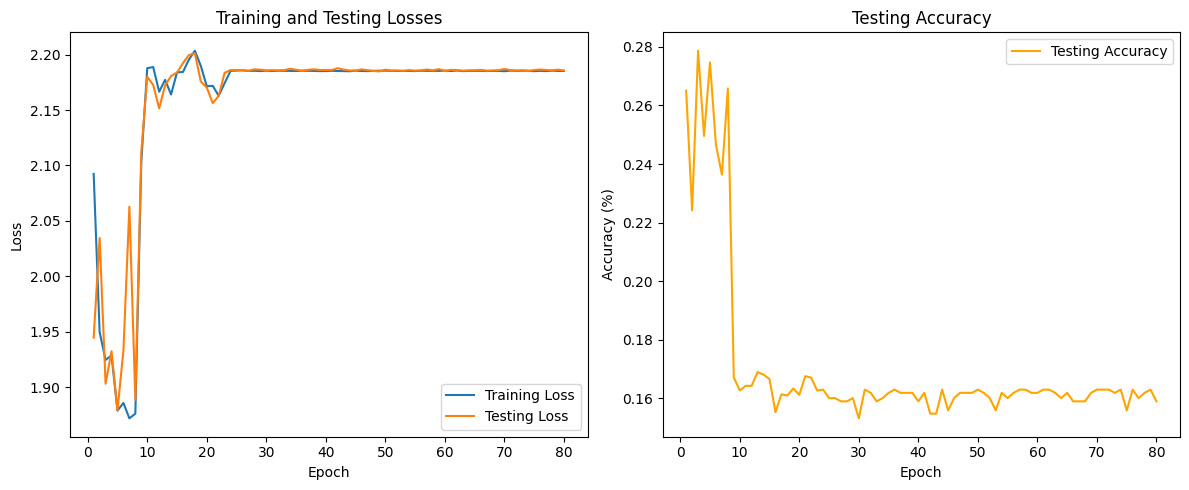

In [19]:
# Move tensors to CPU before plotting
train_avg_loss_cpu = [loss.cpu().item() for loss in train_avg_loss]
test_avg_loss_cpu = [loss.cpu().item() for loss in test_avg_loss]
test_accuracy_cpu = [acc.cpu().item() for acc in test_accuracy]

# Plotting the statistics
plt.figure(figsize=(12, 5))

# Plot training and testing losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_avg_loss_cpu, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_avg_loss_cpu, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()

# Plot testing accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_accuracy_cpu, label='Testing Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Testing Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

We set the input_features to 3072 since its the flattened size of the CIFAR-10 images.

Similarly, we set the output_features to 10 since CIFAR-10 has 10 classes, so the output features is appropriate for multi-class classification with nn.CrossEntropyLoss.

We set hidden_features to 512 because it provide a reasonable balance between model complexity and computational efficiency for the CIFAR-10 dataset.

We set the learning rate to 0.01 as it is a common starting point for optimization algorithms like Adam. It's neither too high, which could lead to overfitting, nor too low, which could slow down the training process.

We set num_epochs to 80 since it provides sufficient training time to observe the model's performance.

## 3.  Create a custom dataset

Sometimes you would like to train a model on your own dataset, which will very likely not be part of `torchvision`. To overcome this you can create a custom dataset class which will handle the data for you. This can be done by inheriting from `torch`'s `data.Dataset` class and defining the methods `__len__` and `__getitem__` (see the [documentation](https://pytorch.org/docs/stable/data.htm)).

In this exercise your goal is to program a custom dataset class which you will later use for training a CNN. We will use the Kaggle Cats and Dogs dataset which you can download from [here](https://www.microsoft.com/en-us/download/details.aspx?id=54765). Note that some images may have different shapes. It is up to you to deal with this elegantly. In addition, some images may be corrupted. You can simply remove those.

When programming a custom dataset class, you have to start by defining the constructor, which will get as input the location of your dataset, whether the images that will be returned will serve for training or testing, and some other potential attributes. For this exercise we will be using 20000 images for training and 5000 images for testing. For the `__getitem__` function you may find the `PIL.Image.open` useful. Do not forget to transform the images into tensors and return the image labels as well ($0$ or $1$).

In [15]:
import os
import random

transform = transforms.Compose([
    transforms.Resize((64, 64)), # Normalize the images shapes
    transforms.ToTensor(),
])

class CatAndDogsDataset(data.Dataset):
    def __init__(self, root_dir, train=True):
        """Initializes a dataset containing images and labels."""
        super().__init__()

        self.root_dir = root_dir
        self.train = train
        if self.train:
            self.num_samples = 20000
        else:
            self.num_samples = 5000
        cat_dir = os.path.join(root_dir, 'Cat')
        dog_dir = os.path.join(root_dir, 'Dog')
        self.samples = []
        for filename in os.listdir(cat_dir):
                img_path = os.path.join(cat_dir, filename)
                self.samples.append((img_path, 0))
        for filename in os.listdir(dog_dir):
                img_path = os.path.join(dog_dir, filename)
                self.samples.append((img_path, 1))
        random.shuffle(self.samples)



    def __len__(self):
        """Returns the size of the dataset."""
        return len(self.samples)

    def __getitem__(self, index):
        """Returns the index-th data item of the dataset."""
        filename, label = self.samples[index]
        try:
          with open(filename, 'rb') as image_file:
              image = Image.open(image_file).convert('RGB')
              image = transform(image)
              return image, label

        except Exception as e: # In case of corrupted images
          print(f"Error loading image {filename}: {e}")
          return None, None




Let us have a quick look at these samples.

In [16]:
my_dataset = CatAndDogsDataset('PetImages/', train=True)
print(my_dataset.__len__())
my_loader = data.DataLoader(my_dataset, batch_size=4, shuffle=True, num_workers=2)

25000


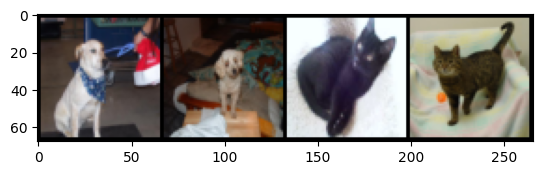

dog dog cat cat


In [25]:
my_dataset = CatAndDogsDataset('PetImages/', train=True)
my_loader = data.DataLoader(my_dataset, batch_size=4, shuffle=True, num_workers=0)

# your code

images, labels = next(iter(my_loader))
show_images(utils.make_grid(images))
classes = ('cat','dog')
print(*[classes[l] for l in labels])

## 4. Classifying the Cats and Dogs dataset with a CNN

As we have seen in class, classifying images with a multi-layer perceptron isn't really a good idea. Convolutional Neural Networks (CNN) are in fact a much better option for this task. It is now your job to create your custom CNN and train it on the Cats and Dogs Dataset.

Similarly to what you have done when classifying the CIFAR10 dataset you are again required to report and discuss the performance of your model.

In [ ]:
input_features = 3
output_features = 2
hidden_features = 512
learning_rate = 0.001
num_epochs = 10
from torchvision.datasets import ImageFolder

class CNN(nn.Module):
    def __init__(self, input_features, output_features, hidden_features):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_features, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.flatten_size = 128 * 8 * 8  # Assuming input images are resized to 64x64
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_size, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, output_features)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output from conv layers
        x = self.classifier(x)
        return x

network = CNN(input_features, output_features, hidden_features)
network.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = data.Subset(my_dataset, range(0, 20000))
testset = data.Subset(my_dataset, range(20000, 25000))

trainloader = data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=0)
testloader = data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=0)

def train(num_epochs):
    train_avg_loss = []
    test_avg_loss = []
    test_accuracy = []

    for epoch in range(num_epochs):
        network.train()
        train_losses = []

        for x, y in trainloader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            pred = network(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        train_avg_loss.append(sum(train_losses) / len(train_losses))
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_avg_loss[-1]}")

        network.eval()
        test_losses = []
        correct = 0
        total = 0

        with torch.no_grad():
            for x, y in testloader:
                x, y = x.to(device), y.to(device)

                pred = network(x)
                loss = criterion(pred, y)
                test_losses.append(loss.item())

                _, predicted = torch.max(pred.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

        test_avg_loss.append(sum(test_losses) / len(test_losses))
        test_accuracy.append(correct / total)

        print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_avg_loss[-1]}, Test Accuracy: {test_accuracy[-1]}")

    return train_avg_loss, test_avg_loss, test_accuracy

In [34]:
train_avg_loss, test_avg_loss, test_accuracy = train(num_epochs)

c:\Users\leiya\anaconda3\envs\dataprj\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch [1/10], Train Loss: 0.6062381601333618
Epoch [1/10], Test Loss: 0.5595235234498978, Test Accuracy: 0.7062
Epoch [2/10], Train Loss: 0.49877252921462056
Epoch [2/10], Test Loss: 0.45051329672336576, Test Accuracy: 0.7878
Epoch [3/10], Train Loss: 0.41406629636883735
Epoch [3/10], Test Loss: 0.40679215908050537, Test Accuracy: 0.8174
Epoch [4/10], Train Loss: 0.3529122053086758
Epoch [4/10], Test Loss: 0.3686341312527657, Test Accuracy: 0.8362
Epoch [5/10], Train Loss: 0.30572968259453775
Epoch [5/10], Test Loss: 0.3585496273636818, Test Accuracy: 0.8432
Epoch [6/10], Train Loss: 0.2645927190035582
Epoch [6/10], Test Loss: 0.35608371555805207, Test Accuracy: 0.8432
Epoch [7/10], Train Loss: 0.21939472325146198
Epoch [7/10], Test Loss: 0.35055811136960985, Test Accuracy: 0.8514
Epoch [8/10], Train Loss: 0.17057003609836102
Epoch [8/10], Test Loss: 0.3896992540359497, Test Accuracy: 0.8526
Epoch [9/10], Train Loss: 0.12921358035877348
Epoch [9/10], Test Loss: 0.4291925942897797, Test

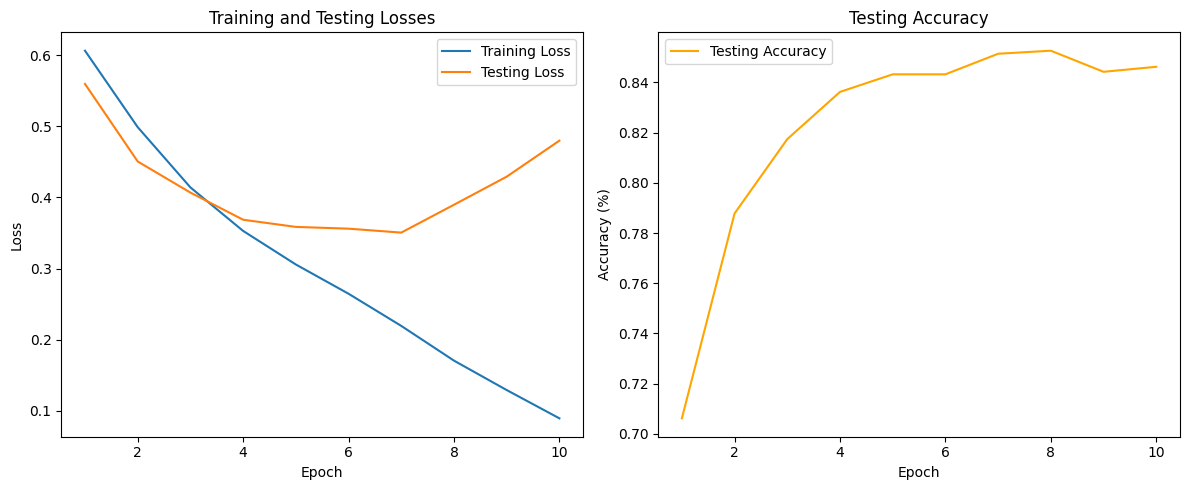

In [35]:
# Use the values directly as they are already floats
train_avg_loss_cpu = train_avg_loss
test_avg_loss_cpu = test_avg_loss
test_accuracy_cpu = test_accuracy

# Plotting the statistics
plt.figure(figsize=(12, 5))

# Plot training and testing losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_avg_loss_cpu, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_avg_loss_cpu, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()

# Plot testing accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_accuracy_cpu, label='Testing Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Testing Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

For a good CNN representation, we would like an accuracy greater than a coin flip, i.e., greater than 50%. In our case, we were able to achieve an accuracy of 84-85%, which seems to be our peak even after tuning parameters.

When each epoch occurs, the train loss continues to decrease each time. More precisely, we notice that the test loss drastically decreases at the beginning until epoch 4, then slowly decreases until epoch 7. However after epoch 7, the test loss increases again. So we get the best accuracy when the epoch is at 7, after that, overfitting starts to occur as there is too much variance. 

Furthermore, even if we did not do it, we could implement a k-fold, do an early stop, or even drop a certain number of neurons to limit the learning. 

Finally, to improve the performance, one idea would be to increase the number of layers. We could add convolution layers to capture more features or do data augmentation because here we just normalize our images to a fixed size.

## Feedback

Now that you are done with this final deep-learning assignment here are some final questions about the exercises you were required to solve:

<span style="color:blue">How much time did you spend on this homework?</span>

<span style="color:blue">Do you feel confortable with what it means to define a neural network and train it?</span>

<span style="color:blue">Do you think you now have enough preliminary knowledge for successfully starting to work on your course final project?</span>

<span style="color:blue">If you had to go through the two homeworks again, is there something you would have liked to explore more or explained more into detail?</span>